# Testing Fourier Feature
By: Ari Silburt  
This is the standard XGBoost classifier algorithm + adding a Fourier feature - divide the short integration timeseries into X subtimeseries, and compare how the fourier spectrum changes in time. For stable systems, the Fourier spectra across time should be very similar. The unstable systems should be different. Start with X=2.

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import peakutils
from scipy import signal
%matplotlib inline

In [5]:
trainData = pd.read_csv('../data/1e7data_train.csv', index_col=0)
testData = pd.read_csv('../data/1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData
df.head()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_min_e2,norm_min_window10_e2,norm_min_e3,norm_min_window10_e3,norm_min_inc1,norm_min_window10_inc1,norm_min_inc2,norm_min_window10_inc2,norm_min_inc3,norm_min_window10_inc3
Sim_ID,,,,,,,,,,,,,,,,,,,,,
2414,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056553,0.013449,0.008127,-4.462116,0.003942,...,0.000304,0.013332,0.000026,0.035966,0.000702,0.000327,0.000850,0.001853,0.000268,0.000527
4056,False,2.980163e+04,10000000.0,0.000015,0.021544,0.050793,0.011447,0.005201,4.606446,0.009269,...,0.000536,0.085972,0.000398,0.009833,0.000102,0.000159,0.000238,0.007656,0.000095,0.000473
4855,True,1.000000e+07,10000000.0,0.000015,0.021544,0.053113,0.012241,0.004883,0.605644,0.000564,...,0.000176,0.048310,0.000261,0.006232,0.000552,0.025484,0.000111,0.000176,0.000191,0.000011
517,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056243,0.013338,0.008056,1.245784,0.007544,...,0.000050,0.004476,0.000432,0.000578,0.000763,0.000076,0.000403,0.002325,0.000358,0.000026
1520,False,2.241913e+04,10000000.0,0.000015,0.021544,0.048262,0.010603,0.012062,-0.577740,0.005068,...,0.000107,0.004912,0.000071,0.025597,0.000004,0.008796,0.000984,0.001798,0.000431,0.027389


In [6]:
df.loc[df.index == 2414,"Norbits_instability"].values[0]

10000000.0

## Make Fourier Features
This is really the only novel part of this notebook

In [7]:
file_location = '../data/featuresfromshortruns/'
ids = df.index
columns = ['Time', 'Lyapunov Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

In [14]:
#Feb. 2017 give this another try
#try a low pass filter on the fft data?

#New approach - divide spectrum in two, find peaks of each spectrum, and measure the deviation of the centroids, 
#between each spectrum. If it's a noisy spectrum, the centroids will be scattered and the deviation will be 
#large. If well defined peaks the centroids should be close...
#Multiplying two fft's together increases SNR, good tactic...
#Do a single peak identification (to get an estimate of number of peaks), then just identify the max values in 
#the array for the other ffts. You don't need to identify gaussians, just peak values. 
dFFT_z = []
id_test = [2414, 4056, 4855, 841, 681, 1569]
labels = ['stable','unstable (1e4 orbits)','stable','unstable (2e6 orbits)','unstable (9e6 orbits)','unstable (1e5 orbits)']
for j,i in enumerate(id_test):
    data = pd.read_csv(file_location+'output%d.csv'%i,header=None,names=columns)
    FFT_pl = []
    for pl in ['1', '2', '3']:
        v = data["e"+pl].values*np.exp(data["pomega"+pl].values*1j)     #z
        #v = data["e"+pl].values
        v1, v2 = v[0:len(v)/2], v[len(v)/2:]
        min_length = min((len(v1), len(v2)))
        v1, v2 = v1[0:min_length], v2[0:min_length]
        hanning = np.hanning(len(v1))
        fft1 = np.abs(np.fft.rfft(v1*hanning))[10:]
        fft2 = np.abs(np.fft.rfft(v2*hanning))[10:]
        i1 = peakutils.indexes(fft1, thres=0.05, min_dist=50)
        i2 = peakutils.indexes(fft2, thres=0.05, min_dist=50)
        #peaks_i1 = peakutils.interpolate(range(len(fft1)), fft1, ind=i1)
        #peaks_i2 = peakutils.interpolate(range(len(fft2)), fft2, ind=i2)
        #i1 = signal.find_peaks_cwt(fft1, np.arange(5,20))
        #plt.plot(fft1), plt.plot(fft2)#, plt.yscale('log')
        #plt.plot(i1, fft1[i1], '+'), plt.plot(i2, fft1[i2], '+')
        plt.plot(fft1, color='blue'), plt.plot(i1,fft1[i1],'+',color='blue',ms=10)
        plt.plot(fft2, color='red'), plt.plot(i2,fft2[i2],'+',color='red',ms=10)
        plt.title(labels[j])
        plt.savefig("id%d_pl%s.png"%(i,pl))
        plt.clf()
    print i, FFT_pl
    dFFT_z.append(FFT_pl)


2414 []
4056 []
4855 []
841 []
681 []
1569 []


In [10]:
#Trying Dan's approach, maybe just sum the total power, since the power will be greatly reduced in fXfY spectra whose
#peaks have shifted. if f1 has a peak at 330Hz and has a width of 10Hz, and f2 has a peak at 340Hz with a width of 
#10Hz, the f1*f2 power will be greatly reduced compared to f1*f1 or f2*f2. 
#The f1f3 power seems to be consistently the lowest, by a significant margin. I wonder if that's because slow drift
#in the parameters over 1e4 years will mean that f1 frequencies are always slightly different from f3, leading to
#significantly reduced power. 

#Seems like the best metric so far is just std(np.sum([fft1,fft2,fft3])), which implies that for stable systems the 
#total power is equally distributed in each segment of the time series, and implies that for unstable systems the
#total power is **not** equally distributed in each segment of the time series... but why? For some reason, total 
#power is not conserved for timeseries of equal length... interesting...
std = []
Norbits = []
std1, std2, std3, std4 = [], [], [], []
for i in ids:
    data = pd.read_csv(file_location+'output%d.csv'%i,header=None,names=columns)
    Norbits.append(df.loc[df.index == i,"Norbits_instability"].values[0])
    std_pl = []
    for pl in ['1', '2', '3']:
        v = data["e"+pl].values*np.exp(data["pomega"+pl].values*1j)     #z
        #v = data["e"+pl].values
        v1, v2, v3 = v[0:len(v)/3], v[len(v)/3:2*len(v)/3], v[2*len(v)/3:]
        min_length = min((len(v1), len(v2), len(v3)))
        v1, v2, v3 = v1[0:min_length], v2[0:min_length], v3[0:min_length]
        hanning = np.hanning(len(v1))
        fft1 = np.abs(np.fft.rfft(v1*hanning))[30:]
        fft2 = np.abs(np.fft.rfft(v2*hanning))[30:]
        fft3 = np.abs(np.fft.rfft(v3*hanning))[30:]
        
        #std1.append(np.sum(fft2*fft1)/np.sum((fft2*fft2))), std2.append(np.sum(fft3*fft2)/np.sum((fft2*fft2)))
        #std3.append(np.sum(fft3*fft1)/np.sum((fft3*fft3))), std4.append(np.sum(fft3*fft2)/np.sum((fft3*fft3)))
        #std_pl = std_pl + [np.sum(fft2*fft1)/np.sum((fft2*fft2)),np.sum(fft3*fft2)/np.sum((fft2*fft2)),np.sum(fft3*fft1)/np.sum((fft3*fft3)),np.sum(fft3*fft2)/np.sum((fft3*fft3)),np.sum(fft2*fft1)/np.sum((fft1*fft1)),np.sum(fft3*fft1)/np.sum((fft1*fft1))]
        std_pl.append(np.std([np.sum(fft1),np.sum(fft2),np.sum(fft3)]))
    std.append(np.max(std_pl))

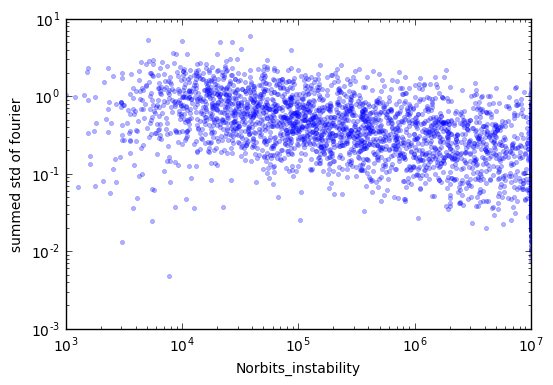

In [11]:
plt.plot(Norbits, std, '.', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=5)
plt.xlabel('Norbits_instability')
plt.ylabel('summed std of fourier')
#plt.ylabel("Planet 2: sum(fft1*fft2)/sum(fft1*fft1)")
plt.savefig('Ari_FFTfeature_std_v_Norbits.png')

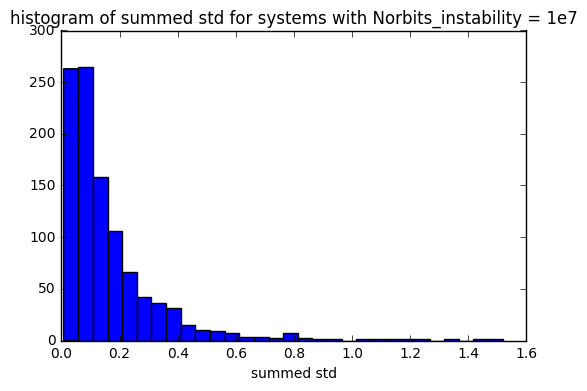

In [14]:
n, bins, patches = plt.hist(np.asarray(std)[np.asarray(Norbits) == 1e7],bins=30)
plt.xlabel('summed std')
#plt.xlabel("Planet 2: sum(fft1*fft2)/sum(fft1*fft1)")
plt.title('histogram of summed std for systems with Norbits_instability = 1e7')
plt.savefig('Ari_FFTfeature_hist.png')

In [19]:
#Trying Dan's approach, maybe just sum the total power, since the power will be greatly reduced in fXfY spectra whose
#peaks have shifted. if f1 has a peak at 330Hz and has a width of 10Hz, and f2 has a peak at 340Hz with a width of 
#10Hz, the f1*f2 power will be greatly reduced compared to f1*f1 or f2*f2. 
#The f1f3 power seems to be consistently the lowest, by a significant margin. I wonder if that's because slow drift
#in the parameters over 1e4 years will mean that f1 frequencies are always slightly different from f3, leading to
#significantly reduced power. 

#Seems like the best metric so far is just std(np.sum([fft1,fft2,fft3])), which implies that for stable systems the 
#total power is equally distributed in each segment of the time series, and implies that for unstable systems the
#total power is **not** equally distributed in each segment of the time series... but why? For some reason, total 
#power is not conserved for timeseries of equal length... interesting...
dFFT_z = []
id_test = [2414, 4056, 4855, 841, 681, 1569]
labels = ['stable','unstable (1e4 orbits)','stable','unstable (2e6 orbits)','unstable (9e6 orbits)','unstable (1e5 orbits)']
for j,i in enumerate(id_test):
    data = pd.read_csv(file_location+'output%d.csv'%i,header=None,names=columns)
    FFT_pl = []
    print i, labels[j]
    for pl in ['1', '2', '3']:
        v = data["e"+pl].values*np.exp(data["pomega"+pl].values*1j)     #z
        #v = data["e"+pl].values
        v1, v2, v3 = v[0:len(v)/3], v[len(v)/3:2*len(v)/3], v[2*len(v)/3:]
        min_length = min((len(v1), len(v2), len(v3)))
        v1, v2, v3 = v1[0:min_length], v2[0:min_length], v3[0:min_length]
        hanning = np.hanning(len(v1))
        fft1 = np.abs(np.fft.rfft(v1*hanning))[20:]
        fft2 = np.abs(np.fft.rfft(v2*hanning))[20:]
        fft3 = np.abs(np.fft.rfft(v3*hanning))[20:]
        i1 = peakutils.indexes(fft1, thres=0.05, min_dist=10)
        i2 = peakutils.indexes(fft2, thres=0.05, min_dist=10)
        i3 = peakutils.indexes(fft3, thres=0.05, min_dist=10)
        f1f1 = fft1*fft1
        f2f2 = fft2*fft2
        f3f3 = fft3*fft3
        f1f2 = fft1*fft2
        f1f3 = fft1*fft3
        f2f3 = fft2*fft3
        i1i1 = peakutils.indexes(f1f1, thres=0.05, min_dist=10)
        i2i2 = peakutils.indexes(f2f2, thres=0.05, min_dist=10)
        i3i3 = peakutils.indexes(f3f3, thres=0.05, min_dist=10)
        i1i2 = peakutils.indexes(f1f2, thres=0.05, min_dist=10)
        i1i3 = peakutils.indexes(f1f3, thres=0.05, min_dist=10)
        i2i3 = peakutils.indexes(f2f3, thres=0.05, min_dist=10)
#        plt.plot(f1f1, color='black'), plt.plot(i1i1,f1f1[i1i1],'+',color='black',ms=10)
        plt.plot(f2f2, color='black'), plt.plot(i2i2,f2f2[i2i2],'+',color='black',ms=10)
#        plt.plot(f3f3, color='dark gray'), plt.plot(i3i3,f3f3[i3i3],'+',color='dark gray')
#        plt.plot(f1f3, color='blue'), plt.plot(i1i3,f1f3[i1i3],'+',color='blue',ms=10)
        plt.plot(f2f3, color='red'), plt.plot(i2i3,f2f3[i2i3],'+',color='red',ms=10)
        plt.plot(f1f2, color='green'), plt.plot(i1i2,f1f2[i1i2],'+',color='green')
        plt.title(labels[j])
        plt.savefig("id%d_pl%s.png"%(i,pl))
        plt.clf()
        print pl, np.std([np.sum(fft1),np.sum(fft2),np.sum(fft3)])
        #print "f1f1:",np.sum(f1f2)/np.sum(f1f1), np.sum(f1f3)/np.sum(f1f1), np.sum(f1f1)
        #print "f2f2:",np.sum(f1f2)/np.sum(f2f2), np.sum(f2f3)/np.sum(f2f2), np.sum(f2f2)
        #print "f3f3:",np.sum(f2f3)/np.sum(f3f3), np.sum(f1f3)/np.sum(f3f3), np.sum(f3f3)
    print i, FFT_pl
    dFFT_z.append(FFT_pl)


2414 stable
1 0.013425964029
2 0.046886210417
3 0.0370149236294
2414 []
4056 unstable (1e4 orbits)
1 0.343599850268
2 0.601179314002
3 0.761606296011
4056 []
4855 stable
1 0.0303743283587
2 0.0296631572063
3 0.0123256528588
4855 []
841 unstable (2e6 orbits)
1 0.159431541237
2 0.221530024243
3 0.143158085381
841 []
681 unstable (9e6 orbits)
1 0.0260776894008
2 0.0117370975466
3 0.015746027279
681 []
1569 unstable (1e5 orbits)
1 0.166528268981
2 0.367158620647
3 0.518368248665
1569 []


### Previous

In [13]:
#New approach - divide spectrum in two, find peaks of each spectrum, and measure the deviation of the centroids, 
#between each spectrum. If it's a noisy spectrum, the centroids will be scattered and the deviation will be 
#large. If well defined peaks the centroids should be close...
#Multiplying two fft's together increases SNR, good tactic...
#Do a single peak identification (to get an estimate of number of peaks), then just identify the max values in 
#the array for the other ffts. You don't need to identify gaussians, just peak values. 
dFFT_z = []
id_test = [2414, 4056, 4855, 841, 681, 1569]
labels = ['stable','unstable (1e4 orbits)','stable','unstable (2e6 orbits)','unstable (9e6 orbits)','unstable (1e5 orbits)']
for j,i in enumerate(id_test):
    data = pd.read_csv(file_location+'output%d.csv'%i,header=None,names=columns)
    FFT_pl = []
    for pl in ['1', '2', '3']:
        v = data["e"+pl].values*np.exp(data["pomega"+pl].values*1j)     #z
        #v = data["e"+pl].values
        v1, v2, v3 = v[0:len(v)/3], v[len(v)/3:2*len(v)/3], v[2*len(v)/3:]
        min_length = min((len(v1), len(v2), len(v3)))
        v1, v2, v3 = v1[0:min_length], v2[0:min_length], v3[0:min_length]
        hanning = np.hanning(len(v1))
        fft1 = np.abs(np.fft.rfft(v1*hanning))[10:]
        fft2 = np.abs(np.fft.rfft(v2*hanning))[10:]
        fft3 = np.abs(np.fft.rfft(v3*hanning))[10:]
        i1 = peakutils.indexes(fft1, thres=0.05, min_dist=10)
        i2 = peakutils.indexes(fft2, thres=0.05, min_dist=10)
        i3 = peakutils.indexes(fft3, thres=0.05, min_dist=10)
        f1f2 = fft1*fft2
        f1f3 = fft1*fft3
        f2f3 = fft2*fft3
        i1i2 = peakutils.indexes(f1f2, thres=0.05, min_dist=10)
        i1i3 = peakutils.indexes(f1f3, thres=0.05, min_dist=10)
        i2i3 = peakutils.indexes(f2f3, thres=0.05, min_dist=10)
        #peaks_i1 = peakutils.interpolate(range(len(fft1)), fft1, ind=i1)
        #peaks_i2 = peakutils.interpolate(range(len(fft2)), fft2, ind=i2)
        #i1 = signal.find_peaks_cwt(fft1, np.arange(5,20))
        #plt.plot(fft1), plt.plot(fft2)#, plt.yscale('log')
        #plt.plot(i1, fft1[i1], '+'), plt.plot(i2, fft1[i2], '+')
        plt.plot(f1f3, color='blue'), plt.plot(i1i3,f1f3[i1i3],'+',color='blue',ms=10)
        plt.plot(f2f3, color='red'), plt.plot(i2i3,f2f3[i2i3],'+',color='red',ms=10)
        plt.plot(f1f2, color='green'), plt.plot(i1i2,f1f2[i1i2],'+',color='green')
        plt.title(labels[j])
        plt.savefig("id%d_pl%s.png"%(i,pl))
        plt.clf()
    print i, FFT_pl
    dFFT_z.append(FFT_pl)


2414 []
4056 []
4855 []
841 []
681 []
1569 []


## Run XGBoost
The rest is business as usual.

In [2]:
features = ['avg_a1', 'std_a1', 'max_a1', 'min_a1', 'norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1', 'avg_a2', 'std_a2', 'max_a2', 'min_a2', 'norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'avg_a3', 'std_a3', 'max_a3', 'min_a3', 'norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3', 'avg_e1', 'std_e1', 'max_e1', 'min_e1', 'norm_std_e1', 'norm_max_e1', 'norm_std_window10_e1', 'norm_max_window10_e1', 'avg_e2', 'std_e2', 'max_e2', 'min_e2', 'norm_std_e2', 'norm_max_e2', 'norm_std_window10_e2', 'norm_max_window10_e2', 'avg_e3', 'std_e3', 'max_e3', 'min_e3', 'norm_std_e3', 'norm_max_e3', 'norm_std_window10_e3', 'norm_max_window10_e3', 'daOvera1', 'daOvera2', 'daOverRH1', 'daOverRH2', 'mindaOvera', 'maxdaOvera', 'mindaOverRH', 'maxdaOverRH']

y = df['Stable']
X = df[features]
X.head()

,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,avg_a2,std_a2,...,norm_std_window10_e3,norm_max_window10_e3,daOvera1,daOvera2,daOverRH1,daOverRH2,mindaOvera,maxdaOvera,mindaOverRH,maxdaOverRH
Sim_ID,,,,,,,,,,,,,,,,,,,,,
2414,0.056538,0.000006,0.056570,0.056528,0.000112,0.000557,0.000091,0.000193,0.067515,0.000014,...,0.114586,0.196496,0.193670,0.150145,8.989360,6.969123,0.150145,0.193670,6.969123,8.989360
4056,0.050704,0.000062,0.050873,0.050535,0.001214,0.003334,0.001208,0.001626,0.057336,0.000090,...,0.240935,0.389639,0.127645,0.109779,5.924768,5.095487,0.109779,0.127645,5.095487,5.924768
4855,0.053119,0.000009,0.053164,0.053108,0.000166,0.000862,0.000054,0.000086,0.061394,0.000012,...,0.069629,0.086331,0.156020,0.180944,7.241825,8.398691,0.156020,0.180944,7.241825,8.398691
517,0.056245,0.000006,0.056277,0.056235,0.000115,0.000579,0.000076,0.000190,0.066963,0.000010,...,0.030994,0.051202,0.190471,0.192685,8.840869,8.943640,0.190471,0.192685,8.840869,8.943640
1520,0.048167,0.000040,0.048313,0.048075,0.000833,0.003023,0.001136,0.001878,0.054468,0.000068,...,0.075764,0.127401,0.127295,0.109568,5.908519,5.085694,0.109568,0.127295,5.085694,5.908519
